In [50]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 999)

In [29]:
survey = pd.read_csv("survey.csv")
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている(AA駅),1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [30]:
survey.isnull().sum()

datetime        0
comment         2
satisfaction    0
dtype: int64

In [31]:
survey = survey.dropna()
survey.isna().sum()

datetime        0
comment         0
satisfaction    0
dtype: int64

In [32]:
# 不要な文字を削除する
survey["comment"] = survey["comment"].str.replace("\(.+?\)", "", regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [33]:
survey["comment"] = survey["comment"].str.replace("\（.+?\）", "", regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる,4
4,2019/1/6,駅前商店街が寂しい,2


In [34]:
survey["length"] = survey["comment"].str.len()
survey.head()

,datetime,comment,satisfaction,length
0,2019/3/11,駅前に若者が集まっている,1,12
1,2019/2/25,スポーツできる場所があるのが良い,5,16
2,2019/2/18,子育て支援が嬉しい,5,9
3,2019/4/9,保育園に入れる,4,7
4,2019/1/6,駅前商店街が寂しい,2,9


(array([11., 24., 21., 10.,  6.,  6.,  5.,  0.,  0.,  1.]),
 array([ 4. ,  8.6, 13.2, 17.8, 22.4, 27. , 31.6, 36.2, 40.8, 45.4, 50. ]),
 <a list of 10 Patch objects>)

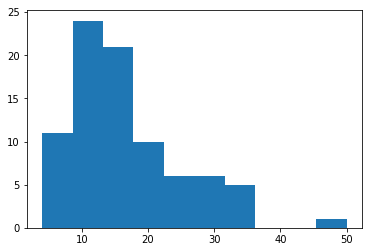

In [35]:
# 文字数のヒストグラムを作る
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(survey["length"])

In [36]:
import MeCab
tagger = MeCab.Tagger()
text = "すもももももももものうち"
words = tagger.parse(text)
print(words)

すもも	名詞,一般,*,*,*,*,すもも,スモモ,スモモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
も	助詞,係助詞,*,*,*,*,も,モ,モ
もも	名詞,一般,*,*,*,*,もも,モモ,モモ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
うち	名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ
EOS



In [37]:
words = tagger.parse(text).splitlines()
word_attr = []
for i in words:
    if i == "EOS": continue
    word = i.split()[0]
    word_attr.append(word)
word_attr

['すもも', 'も', 'もも', 'も', 'もも', 'の', 'うち']

In [100]:
# 動詞・名詞だけを抽出する
def extract_noun_list(text, stop_word_list):
    words = tagger.parse(text).splitlines()
    targets = ["名詞"]
    word_attr = []
    for i in words:
        if i == "EOS": continue
        part = i.split()[1].split(",")[0]
        if not part in targets: continue
        word = i.split()[0]
        if not word in stop_word_list:
            word_attr.append(word)
    return word_attr

extract_noun_list(text, ["の"])

['すもも', 'もも', 'もも', 'うち']

In [101]:
# commentで頻出する名詞を確認する
from functools import reduce
noun_list = []
stop_word_list = ["の"]
for comment in survey["comment"]:
    word = extract_noun_list(comment, stop_word_list)
    noun_list.append(word)

all_words = reduce(lambda a, b: a + b, noun_list)
len(all_words)

276

In [103]:
all_words_df = pd.DataFrame({"words": all_words, "count": len(all_words)*[1]})
all_words_df.head()
all_words_df = all_words_df.groupby("words", ).sum()
all_words_df.sort_values("count", ascending=False).reset_index().head()

#　ここから、駅前、公園、街などの意見が多いことがわかる

,words,count
0,駅前,7
1,場所,6
2,街,6
3,公園,5
4,商店,5


In [147]:
# aaa = [(["駅前", "街"], 1), (["駅", "公園"], 4)]
# aaa[0][0]
def extract_noun_satisfaction_list(survey, stop_word_list):
    words = tagger.parse(survey["comment"]).splitlines()
    targets = ["名詞"]
    word_list = []
    for i in words:
        if i == "EOS": continue
        part = i.split()[1].split(",")[0]
        if not part in targets: continue
        word = i.split()[0]
        if not word in stop_word_list:
            word_list.append(word)
    return (word_list, survey["satisfaction"])

word_satisfaction_list = []
for i in range(len(survey)):
    word_satisfaction_list.append(extract_noun_satisfaction_list(survey.iloc[i], ["の"]))

# word_satisfaction_list


# wordだけのリストを作成する
word_list = []
for l in word_satisfaction_list:
    word_list.append(l[0])

word_list = reduce(lambda a, b: a + b, word_list)


# 満足度だけのリストを作成する
satisfaction_list = []
for l in word_satisfaction_list:
    for w in l[0]:
        satisfaction_list.append(l[1])
satisfaction_list

word_satisfaction_list_df = pd.DataFrame({"words": word_list, "satisfaction": satisfaction_list, "count": len(word_list)*[1]})
word_satisfaction_list_df.head()

,words,satisfaction,count
0,駅前,1,1
1,若者,1,1
2,スポーツ,5,1
3,場所,5,1
4,子育て,5,1


In [158]:
word_satisfaction = word_satisfaction_list_df.groupby("words").mean()["satisfaction"]
word_count = word_satisfaction_list_df.groupby("words").sum()["count"]
words_df = pd.concat([word_satisfaction, word_count], axis=1)
words_df.head()

,satisfaction,count
words,,
BBB,2.0,1
^^,5.0,1
おじさん,1.0,1
ごみ,2.0,1
そう,1.0,1


In [161]:
# countが3以上、顧客満足度の降順に並べる
words_df.loc[words_df["count"] >= 3].sort_values("satisfaction", ascending=False).head()

,satisfaction,count
words,,
子育て,4.333333,3
綺麗,4.333333,3
安心,4.333333,3
スポーツ,3.666667,3
道,3.000000,3


In [164]:
words_df.loc[words_df["count"] >= 3].sort_values("satisfaction", ascending=True).head()

# これで、大まかなアンケートの内容・状況を把握できた

,satisfaction,count
words,,
駐車,1.000000,4
場,1.000000,4
信号,1.333333,3
大変,1.333333,3
駅前,1.428571,7


In [298]:
# 実際に、アンケートコメントにどのような特徴があるのか分類してみる

# 形態素形跡した文字をカラムに入れて、レコード毎にその文字が存在していれば1をvalueとして登録する

# 形態素解析されたwordのリストを返す
def extract_word(servey, stop_word_list):
    comment = servey["comment"]
    words = tagger.parse(comment).splitlines()
    target_list = ["名詞"]
    word_list = []
    for i in range(len(words)):
        word = words[i].split()[0]
        if word == "EOS" or word in stop_word_list: continue
        noun = words[i].split()[1].split(",")[0]
        if not noun in target_list: continue
        word_list.append(word)
    return word_list


limited_survey = survey[["comment", "satisfaction"]]
limited_survey.head()
stop_word_list2 = ["の"]
all_word_df = pd.DataFrame()
for i in range(len(limited_survey)):
    word_df = pd.DataFrame()
    word_list = extract_word(limited_survey.iloc[i], stop_word_list2)
    for l in word_list:
        word_df[l] = [1]
    all_word_df = pd.concat([all_word_df, word_df], ignore_index=True)
all_word_df.head(10)

,BBB,^^,おじさん,ごみ,そう,たくさん,づくり,とき,まち,よう,アクセス,アンケート,コース,ゴミ,サイクリング,サポート,ジム,スポット,スポーツ,スーパー,デートスポット,ナンバー,バス,ホームページ,マスコット,...,路面,車,近く,追加,遊び,運動,道,道具,道路,避難,都内,野良猫,防止,防犯,隣,雨,電話,頻繁,館,駅前,駐車,駐輪場,高速,高齢,ｘｘｘ
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [299]:
# 欠損値を補完する
all_word_df = all_word_df.fillna(0)
all_word_df.head()
pd.concat([limited_survey, all_word_df], axis=1).head()

,comment,satisfaction,BBB,^^,おじさん,ごみ,そう,たくさん,づくり,とき,まち,よう,アクセス,アンケート,コース,ゴミ,サイクリング,サポート,ジム,スポット,スポーツ,スーパー,デートスポット,ナンバー,バス,...,路面,車,近く,追加,遊び,運動,道,道具,道路,避難,都内,野良猫,防止,防犯,隣,雨,電話,頻繁,館,駅前,駐車,駐輪場,高速,高齢,ｘｘｘ
0,駅前に若者が集まっている,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,スポーツできる場所があるのが良い,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,子育て支援が嬉しい,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,保育園に入れる,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,駅前商店街が寂しい,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [318]:
# 実際に類似アンケートの検索をやってみる
target_text = survey.iloc[2]["comment"]
target_text = all_word_df.iloc[2]
print(target_text) 
# 「子育て支援が嬉しい」コメントのレコードを取得している
# 下で行う、コサイン類似度計算のために、行列が必要になるので、一行そのまま取得している

BBB        0.0
^^         0.0
おじさん       0.0
ごみ         0.0
そう         0.0
たくさん       0.0
づくり        0.0
とき         0.0
まち         0.0
よう         0.0
アクセス       0.0
アンケート      0.0
コース        0.0
ゴミ         0.0
サイクリング     0.0
サポート       0.0
ジム         0.0
スポット       0.0
スポーツ       0.0
スーパー       0.0
デートスポット    0.0
ナンバー       0.0
バス         0.0
ホームページ     0.0
マスコット      0.0
ママ         0.0
ランニング      0.0
リーズナブル     0.0
不便         0.0
不安         0.0
不正         0.0
並木         0.0
事          0.0
事件         0.0
事故         0.0
交差点        0.0
企業         0.0
便利         0.0
保育園        0.0
信号         0.0
備蓄         0.0
充実         0.0
先月         0.0
公共         0.0
公園         0.0
公害         0.0
冬場         0.0
凍結         0.0
処理         0.0
出張所        0.0
利用         0.0
動物         0.0
化          0.0
反映         0.0
商店         0.0
商業         0.0
喫茶店        0.0
団          0.0
園          0.0
土日         0.0
地          0.0
地域         0.0
場          0.0
場所         0.0
声          0.0
変          0.0
夜道        

In [324]:
# 類似度計算する
# コサイン類似度を求める

import numpy as np
cos_sim = []
for i in range(len(all_word_df)):
    cos_text = all_word_df.iloc[i]
    cos = np.dot(target_text, cos_text) / (np.linalg.norm(target_text) * np.linalg.norm(cos_text)) # コサイン類似度を計算している
    cos_sim.append(cos)
cos_sim
all_word_df["cos_sim"] = cos_sim
all_word_df.sort_values("cos_sim", ascending=False).head(10)


# これで、各行に対してのコサイン類似度を計算できた
# 実際に、コサイン類似度が高い上位5件の行を見てみる

,BBB,^^,おじさん,ごみ,そう,たくさん,づくり,とき,まち,よう,アクセス,アンケート,コース,ゴミ,サイクリング,サポート,ジム,スポット,スポーツ,スーパー,デートスポット,ナンバー,バス,ホームページ,マスコット,...,車,近く,追加,遊び,運動,道,道具,道路,避難,都内,野良猫,防止,防犯,隣,雨,電話,頻繁,館,駅前,駐車,駐輪場,高速,高齢,ｘｘｘ,cos_sim
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.931607
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836821
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.836821
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.582135
50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.436445
55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
61,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
59,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [331]:
print("target: {}".format(survey.iloc[2]["comment"]))

print(survey.iloc[24]["comment"])
print(survey.iloc[15]["comment"])
print(survey.iloc[33]["comment"])
print(survey.iloc[50]["comment"])
print(survey.iloc[55]["comment"])
print(survey.iloc[62]["comment"])

# 24 ~ 50がコサイン類似度が高いもの
# 55 62は、コサイン類似度が0のもの

# 24 ~ 50のものは、ターゲットのテキストと大枠似たようなテキストになっている

target: 子育て支援が嬉しい
子育てがしやすい
子育てしやすい
働くママの支援をもっと増やして欲しい
地域の自治体をもっと支援してほしい
歩行者用信号が変わるのが早い。老人や子供の事を考えて設定してほしい
先月の職員不正事件について、もっと詳細に説明してほしい
